In [ ]:
!pip install ta
!pip install pandas_ta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import pandas_ta as ta
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn import mixture as mix

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=c79f9ad122f4aa3ca2078cf455d4c8f6a1c381ca3561281efa4b2dea991e1e2d
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=3dffbc7a663f17d468613343226ca8d2cdb6044aff98a0b3b8f3a1ce5924b5f5
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
df =pd.read_csv('btc_18_22_15m.csv')

#cols = df.columns + '_l'
h_10 =pd.read_csv('btc_18_22_4h.csv' )
h_10.rename( columns = { 'datetime' : 'datetime_l' , 'open':'open_l' , 'high':'high_l' , 'low' : 'low_l' , 'close':'close_l', 'volume': 'volume_l'} , inplace = True)
h_10['supertrend_l'] = ta.supertrend(high=h_10.high_l,low = h_10.low_l,close = h_10.close_l,length = 10 ,multiplier = 3)['SUPERT_10_3.0']
h_10['signal_l'] = np.where(h_10['close_l']>h_10['supertrend_l'],1 , np.nan)
h_10['signal_l'] = np.where(h_10['close_l']<h_10['supertrend_l'],-1 , h_10['signal_l'])
#h_10['signal_l']  = h_10['signal_l'].shift(1)

df['datetime'] = [str(df['datetime'].iloc[i])  for i in range(len(df)) ]
df = df.join(h_10.set_index('datetime_l' , drop = True ), on = 'datetime' )
df.fillna( method= 'ffill' , inplace = True )

df

,datetime,open,high,low,close,volume,open_l,high_l,low_l,close_l,volume_l,supertrend_l,signal_l
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13556.15,123.616013,13715.65,13715.65,13155.38,13410.03,1676.204807,0.000000,1.0
1,2018-01-01 05:45:00,13533.75,13550.87,13402.00,13521.12,98.136430,13715.65,13715.65,13155.38,13410.03,1676.204807,0.000000,1.0
2,2018-01-01 06:00:00,13500.00,13545.37,13450.00,13470.41,79.904037,13715.65,13715.65,13155.38,13410.03,1676.204807,0.000000,1.0
3,2018-01-01 06:15:00,13494.65,13690.87,13450.00,13529.01,141.699719,13715.65,13715.65,13155.38,13410.03,1676.204807,0.000000,1.0
4,2018-01-01 06:30:00,13528.99,13571.74,13402.28,13445.63,72.537533,13715.65,13715.65,13155.38,13410.03,1676.204807,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174669,2022-12-31 04:30:00,16582.81,16599.82,16568.00,16593.88,1710.266190,16525.91,16677.35,16523.91,16607.48,24063.452570,16802.382899,-1.0
174670,2022-12-31 04:45:00,16593.88,16599.73,16586.94,16595.48,904.073200,16525.91,16677.35,16523.91,16607.48,24063.452570,16802.382899,-1.0
174671,2022-12-31 05:00:00,16595.03,16618.58,16589.96,16615.56,1374.843200,16525.91,16677.35,16523.91,16607.48,24063.452570,16802.382899,-1.0
174672,2022-12-31 05:15:00,16615.97,16618.75,16598.58,16607.48,997.158880,16525.91,16677.35,16523.91,16607.48,24063.452570,16802.382899,-1.0


In [ ]:
#slice_ = int( len(h_10)*0.7 )
#h_10 = h_10[ : slice_].copy()
#ind = df[df.datetime == h_10.datetime_l.iloc[-1]].index[0]
#df1 = df[:ind].copy()

df1 = df.copy()
df1['%']= df1.close.pct_change()
df1['mean']   = df1['%'].rolling(1000).mean()
df1['std'] = df1['%'].rolling(1000).std()
df1['skew'] =  df1['%'].rolling(1000).skew()
df1['kurtosis'] =  df1['%'].rolling(1000).kurt()

df1.dropna(inplace = True)

dff = df1[['mean' , 'std']].copy()

ss= StandardScaler()

unsup = mix.GaussianMixture( n_components = 4 , \
                      covariance_type = 'spherical' ,\
                      n_init = 100 ,\
                      random_state = 42)


unsup.fit(  ss.fit_transform(dff) )
regime = unsup.predict( ss.transform(dff) )

df1['regime'] = regime
df1


,datetime,open,high,low,close,volume,open_l,high_l,low_l,close_l,volume_l,supertrend_l,signal_l,%,mean,std,skew,kurtosis,regime
1000,2018-01-11 17:15:00,13397.56,13504.85,13300.15,13385.10,309.207679,13530.42,13896.70,13041.00,13385.10,3680.231771,15742.893231,-1.0,-0.001112,0.000027,0.008903,-0.494227,8.015566,1
1001,2018-01-11 17:30:00,13385.10,13679.85,13282.13,13631.55,377.771741,13385.10,14400.00,13282.13,13958.08,4441.493462,15742.893231,-1.0,0.018412,0.000048,0.008921,-0.489416,7.946780,1
1002,2018-01-11 17:45:00,13644.16,13699.00,13524.00,13572.02,216.887789,13385.10,14400.00,13282.13,13958.08,4441.493462,15742.893231,-1.0,-0.004367,0.000047,0.008921,-0.489206,7.945276,1
1003,2018-01-11 18:00:00,13571.99,13723.97,13489.50,13670.00,203.192199,13385.10,14400.00,13282.13,13958.08,4441.493462,15742.893231,-1.0,0.007219,0.000050,0.008923,-0.489461,7.937210,1
1004,2018-01-11 18:15:00,13683.19,13942.45,13670.00,13803.00,250.150663,13385.10,14400.00,13282.13,13958.08,4441.493462,15742.893231,-1.0,0.009729,0.000066,0.008926,-0.492690,7.926796,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174669,2022-12-31 04:30:00,16582.81,16599.82,16568.00,16593.88,1710.266190,16525.91,16677.35,16523.91,16607.48,24063.452570,16802.382899,-1.0,0.000640,-0.000013,0.000976,-0.032905,10.183267,0
174670,2022-12-31 04:45:00,16593.88,16599.73,16586.94,16595.48,904.073200,16525.91,16677.35,16523.91,16607.48,24063.452570,16802.382899,-1.0,0.000096,-0.000012,0.000976,-0.033730,10.183687,0
174671,2022-12-31 05:00:00,16595.03,16618.58,16589.96,16615.56,1374.843200,16525.91,16677.35,16523.91,16607.48,24063.452570,16802.382899,-1.0,0.001210,-0.000012,0.000977,-0.034093,10.151320,0
174672,2022-12-31 05:15:00,16615.97,16618.75,16598.58,16607.48,997.158880,16525.91,16677.35,16523.91,16607.48,24063.452570,16802.382899,-1.0,-0.000486,-0.000011,0.000976,-0.034142,10.196305,0


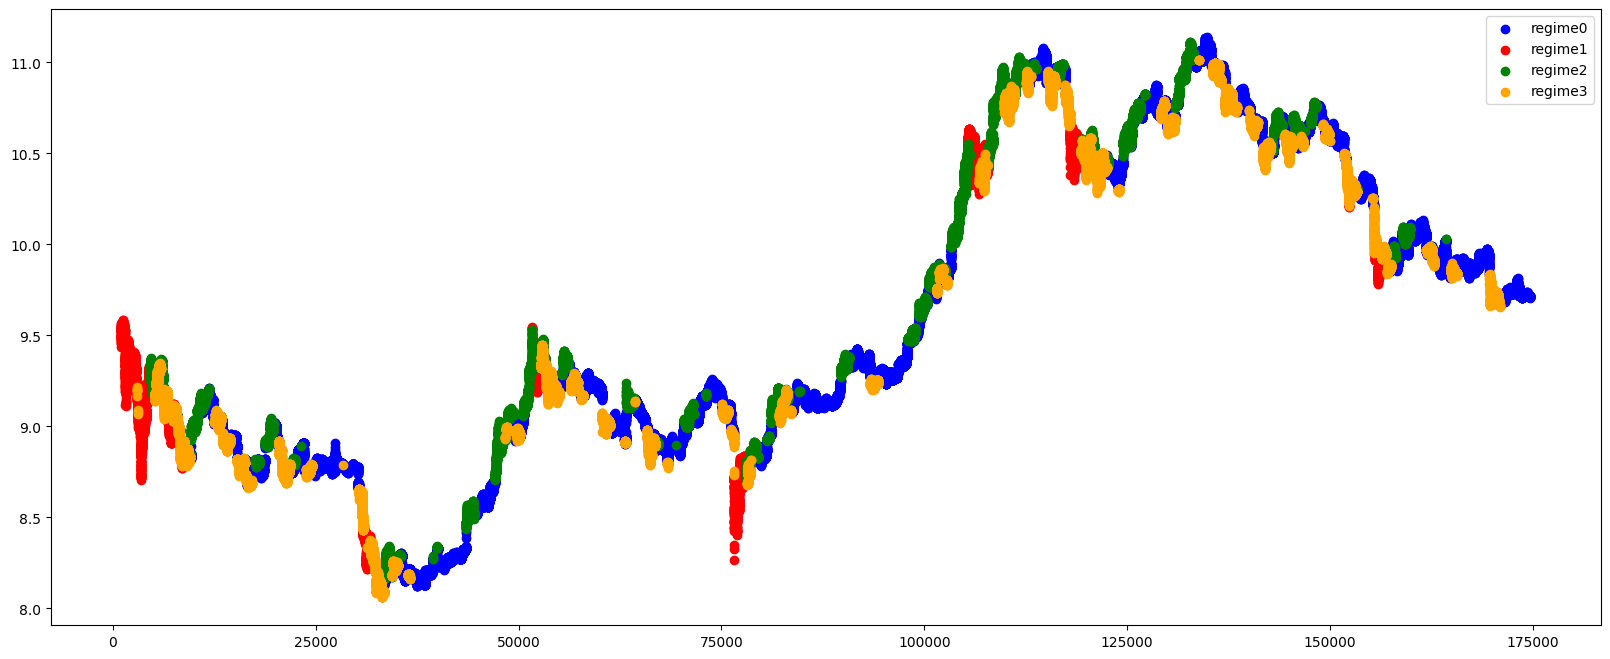

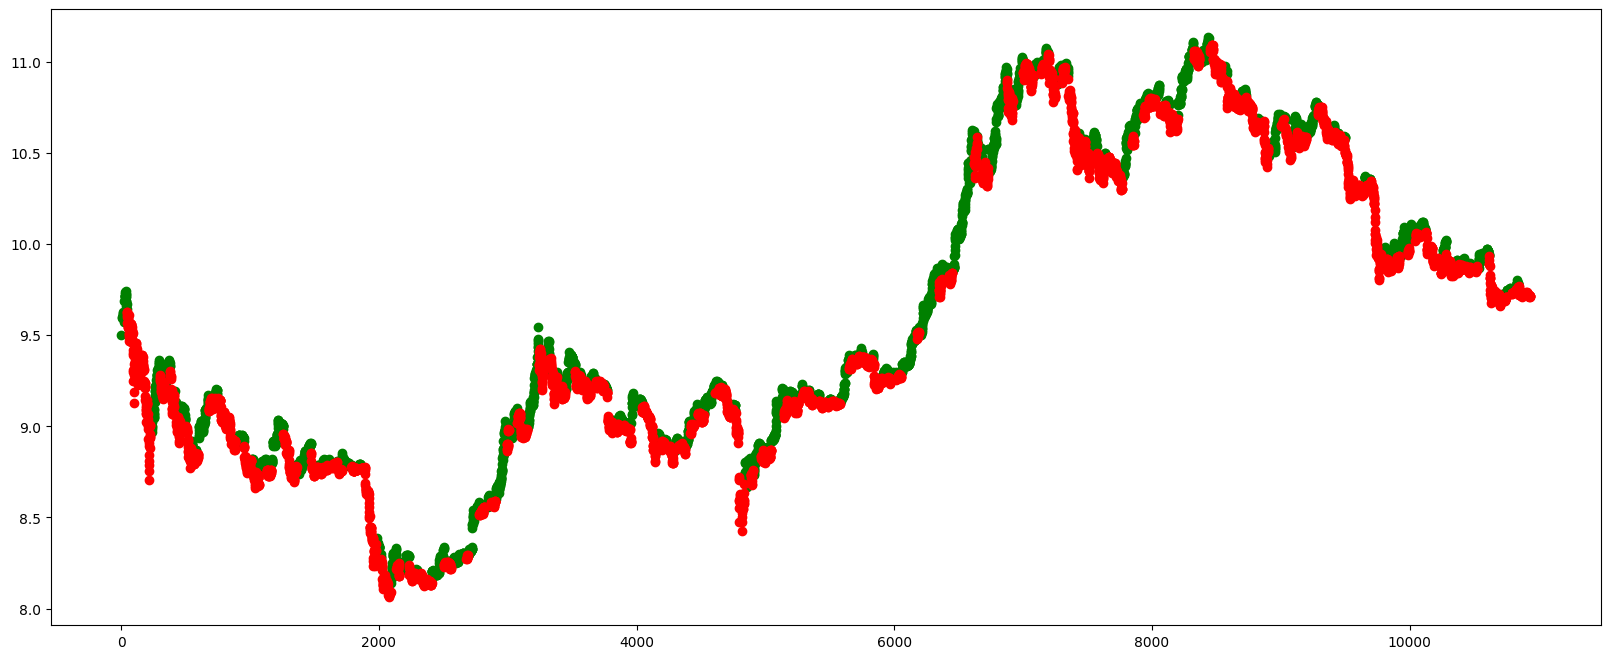

In [ ]:
df1['log_close'] = np.log(df1.close)
df1['regime0'] = np.where( df1.regime ==0 , df1.log_close , np.nan)
df1['regime1'] = np.where( df1.regime ==1 , df1.log_close , np.nan)
df1['regime2'] = np.where( df1.regime ==2 , df1.log_close , np.nan)
df1['regime3'] = np.where( df1.regime ==3 , df1.log_close , np.nan)
plt.figure(figsize =( 20,8))
plt.scatter ( df1.index , df1['regime0'] , color = 'blue' )
plt.scatter ( df1.index , df1['regime1'] , color = 'red' )
plt.scatter ( df1.index , df1['regime2'] , color = 'green'  )
plt.scatter ( df1.index , df1['regime3'], color = 'orange')
plt.legend(['regime0','regime1' , 'regime2' , 'regime3'])

#h_10['log_close_l'] = np.log(h_10.close_l)
#h_10['regime0_l'] = np.where( h_10.regime_l ==0 , h_10.log_close_l , np.nan)
#h_10['regime1_l'] = np.where( h_10.regime_l ==1 , h_10.log_close_l , np.nan)
#h_10['regime2_l'] = np.where( h_10.regime_l ==2 , h_10.log_close_l , np.nan)
#h_10['regime3_l'] = np.where( h_10.regime_l ==3 , h_10.log_close_l , np.nan)
#plt.figure(figsize =( 20,8))
#plt.scatter ( h_10.index , h_10['regime0_l'] , color = 'green' )
#plt.scatter ( h_10.index , h_10['regime1_l'] , color = 'orange' )
#plt.scatter ( h_10.index , h_10['regime2_l'] , color = 'blue'  )
#plt.scatter ( h_10.index , h_10['regime3_l'], color = 'red')
#plt.legend(['regime0_l','regime1_L' , 'regime2_l' , 'regime3_l'])

h_10['log_close_l'] = np.log(h_10.close_l)
h_10['regime0_l'] = np.where( h_10.signal_l == 1 , h_10.log_close_l , np.nan)
h_10['regime1_l'] = np.where( h_10.signal_l == -1 , h_10.log_close_l , np.nan)
plt.figure(figsize =( 20,8))
plt.scatter ( h_10.index , h_10['regime0_l'] , color = 'green' )
plt.scatter ( h_10.index , h_10['regime1_l'] , color = 'red' )

In [ ]:
import scipy.stats
from scipy.stats import skew
from scipy.stats import kurtosis

df_par =   pd.DataFrame( [  [ np.mean(df1[df1.regime == rg]['mean'].to_list()),     \
                              np.mean(df1[df1.regime == rg]['std'].to_list())  ]    \
                              for rg in [0,1,2,3]  ] ,                              \
                              columns = ['mean' , 'std']   )


df_par = df_par *1000
df_par.index = ['regime0' , 'regime1' , 'regime2' , 'regime3']
print(df_par)


             mean       std
regime0  0.013072  2.744739
regime1 -0.089554  9.412752
regime2  0.177811  4.248289
regime3 -0.111795  4.594173


In [ ]:
df1

,datetime,open,high,low,close,volume,open_l,high_l,low_l,close_l,...,mean,std,skew,kurtosis,regime,log_close,regime0,regime1,regime2,regime3
1000,2018-01-11 17:15:00,13397.56,13504.85,13300.15,13385.10,309.207679,13530.42,13896.70,13041.00,13385.10,...,0.000027,0.008903,-0.494227,8.015566,1,9.501897,NaN,9.501897,NaN,NaN
1001,2018-01-11 17:30:00,13385.10,13679.85,13282.13,13631.55,377.771741,13385.10,14400.00,13282.13,13958.08,...,0.000048,0.008921,-0.489416,7.946780,1,9.520142,NaN,9.520142,NaN,NaN
1002,2018-01-11 17:45:00,13644.16,13699.00,13524.00,13572.02,216.887789,13385.10,14400.00,13282.13,13958.08,...,0.000047,0.008921,-0.489206,7.945276,1,9.515766,NaN,9.515766,NaN,NaN
1003,2018-01-11 18:00:00,13571.99,13723.97,13489.50,13670.00,203.192199,13385.10,14400.00,13282.13,13958.08,...,0.000050,0.008923,-0.489461,7.937210,1,9.522959,NaN,9.522959,NaN,NaN
1004,2018-01-11 18:15:00,13683.19,13942.45,13670.00,13803.00,250.150663,13385.10,14400.00,13282.13,13958.08,...,0.000066,0.008926,-0.492690,7.926796,1,9.532641,NaN,9.532641,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174669,2022-12-31 04:30:00,16582.81,16599.82,16568.00,16593.88,1710.266190,16525.91,16677.35,16523.91,16607.48,...,-0.000013,0.000976,-0.032905,10.183267,0,9.716789,9.716789,NaN,NaN,NaN
174670,2022-12-31 04:45:00,16593.88,16599.73,16586.94,16595.48,904.073200,16525.91,16677.35,16523.91,16607.48,...,-0.000012,0.000976,-0.033730,10.183687,0,9.716886,9.716886,NaN,NaN,NaN
174671,2022-12-31 05:00:00,16595.03,16618.58,16589.96,16615.56,1374.843200,16525.91,16677.35,16523.91,16607.48,...,-0.000012,0.000977,-0.034093,10.151320,0,9.718095,9.718095,NaN,NaN,NaN
174672,2022-12-31 05:15:00,16615.97,16618.75,16598.58,16607.48,997.158880,16525.91,16677.35,16523.91,16607.48,...,-0.000011,0.000976,-0.034142,10.196305,0,9.717608,9.717608,NaN,NaN,NaN


In [ ]:
bol_b = (df1['signal_l'] == 1)  &  ( (df1['regime'] == 0) | (df1['regime'] == 2) )
bol_s = (df1['signal_l'] == -1)  &  ( (df1['regime'] == 1) | (df1['regime'] == 3) )
df1['signal'] = np.where( bol_b  , 1 , np.nan )
df1['signal'] = np.where( bol_s  , -1 , df1['signal'] )

df1['signal'] = df1['signal'].shift(1)
df1['c_signal'] = df1['signal']

df1['pct_change'] = df1['close'].pct_change()*100
df1['pnl'] = df1['c_signal'].replace(np.nan,0)*df1['pct_change']

df1['trades'] = np.where( df1.c_signal.replace(np.nan,0) != df1.c_signal.shift(1).replace(np.nan,0) , 1, 0)
df1['trades'] = np.where( (df1['trades'] == 1)  & (df1.c_signal.replace(np.nan,0) == 0)  , 0 , df1['trades'])

STRATEGY RETURS785.8581496501452 
BUY&HLD RETURNS 181.55516624319483


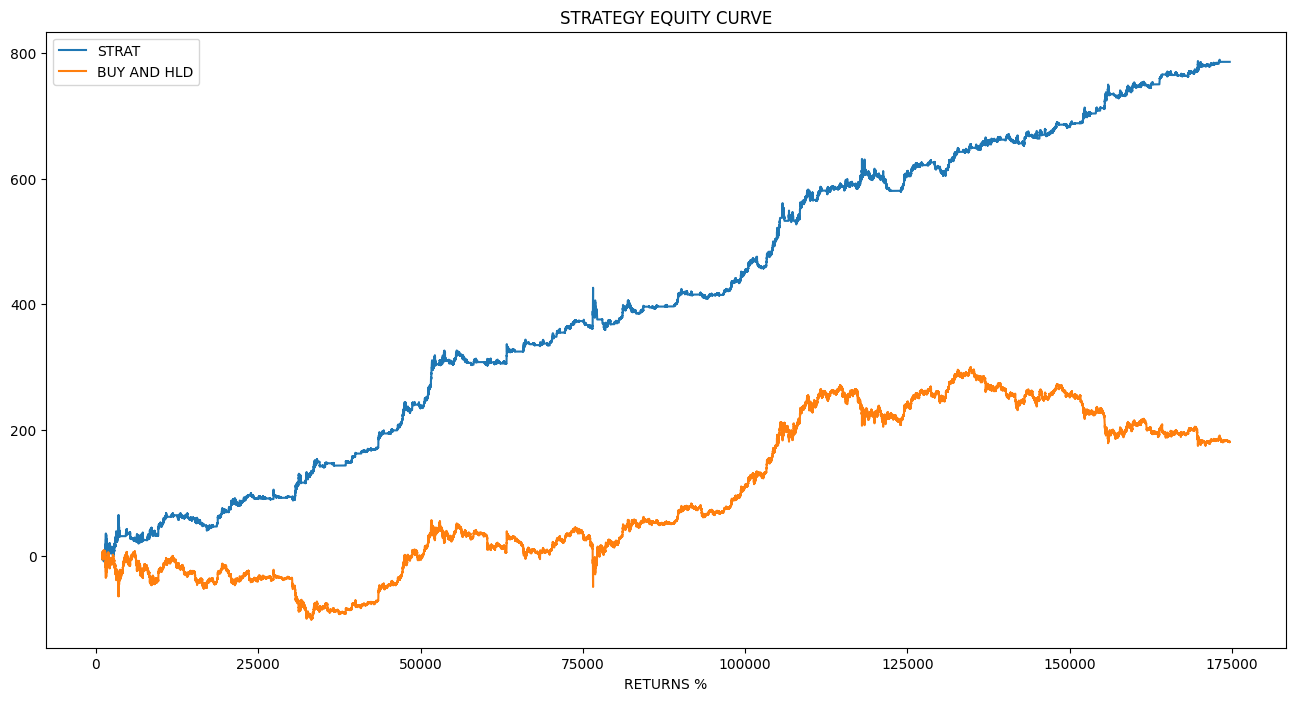

In [ ]:
plt.figure(figsize = (16,8))
plt.plot(df1['pnl'].cumsum())
plt.plot(df1['pct_change'].cumsum())
plt.xlabel( 'TICKS')
plt.xlabel( 'RETURNS %')
plt.title('STRATEGY EQUITY CURVE')
plt.legend( ['STRAT' , 'BUY AND HLD'] )
print( 'STRATEGY RETURS{} '.format(df1['pnl'].cumsum().iloc[-1]) )
print('BUY&HLD RETURNS {}'.format(df1['pct_change'].cumsum().iloc[-1]) )

In [ ]:
pd.read_csv('BTC_23_15m.csv')

,Unnamed: 0,datetime,open,high,low,close,volume
0,0,2023-01-01 05:30:00,16541.77,16544.76,16520.00,16520.69,1172.53835
1,1,2023-01-01 05:45:00,16521.26,16545.70,16517.72,16544.19,1102.62888
2,2,2023-01-01 06:00:00,16544.19,16544.61,16508.39,16515.43,1365.65633
3,3,2023-01-01 06:15:00,16515.91,16536.84,16515.43,16529.67,724.01214
4,4,2023-01-01 06:30:00,16529.59,16541.80,16525.78,16538.21,977.24680
...,...,...,...,...,...,...,...
35031,35031,2024-01-01 04:30:00,42257.89,42345.65,42196.61,42230.13,637.99923
35032,35032,2024-01-01 04:45:00,42230.14,42235.09,42066.00,42181.80,614.77027
35033,35033,2024-01-01 05:00:00,42181.81,42242.95,42154.34,42241.09,215.21045
35034,35034,2024-01-01 05:15:00,42241.09,42283.59,42221.22,42283.58,242.15726


In [ ]:
df =pd.read_csv('data_2020_2023_15min.csv')
df['%'] = df.close.pct_change()
df['mean'] = df['%'].rolling(1000).mean()
df['std'] =  df['%'].rolling(1000).std()

h_10 =pd.read_csv('data_2020_2023_4h.csv' )
h_10.rename( columns = { 'datetime' : 'datetime_l' , 'open':'open_l' , 'high':'high_l' , 'low' : 'low_l' , 'close':'close_l', 'volume': 'volume_l'} , inplace = True)
h_10['supertrend_l'] = ta.supertrend(high=h_10.high_l,low = h_10.low_l,close = h_10.close_l,length = 10 ,multiplier = 3)['SUPERT_10_3.0']
h_10['signal_l'] = np.where(h_10['close_l']>h_10['supertrend_l'],1 , np.nan)
h_10['signal_l'] = np.where(h_10['close_l']<h_10['supertrend_l'],-1 , h_10['signal_l'])

df['datetime'] = [str(df['datetime'].iloc[i])  for i in range(len(df)) ]
df = df.join(h_10.set_index('datetime_l' , drop = True ), on = 'datetime' )
df.fillna( method= 'ffill' , inplace = True )


FileNotFoundError: [Errno 2] No such file or directory: 'data_2020_2023_15min.csv'

In [ ]:
indx = df[df['datetime'] == '2023-01-01 05:30:00'].index[0]
df = df[indx:].copy()

In [ ]:
dff = df[['mean' , 'std']].copy()

regime = unsup.predict( ss.transform(dff) )

df['regime'] = regime


In [ ]:
bol_b = (df['signal_l'] == 1)  &  ( (df['regime'] == 0) | (df['regime'] == 2) )
bol_s = (df['signal_l'] == -1)  &  ( (df['regime'] == 1) | (df['regime'] == 3) )
df['signal'] = np.where( bol_b  , 1 , np.nan )
df['signal'] = np.where( bol_s  , -1 , df['signal'] )

df['signal'] = df['signal'].shift(1)
df['c_signal'] = df['signal']

df['pct_change'] = df['close'].pct_change()*100
df['pnl'] = df['c_signal'].replace(np.nan,0)*df['pct_change']

df['trades'] = np.where( df.c_signal.replace(np.nan,0) != df.c_signal.shift(1).replace(np.nan,0) , 1, 0)
df['trades'] = np.where( (df['trades'] == 1)  & (df.c_signal.replace(np.nan,0) == 0)  , 0 , df['trades'])

STRATEGY RETURS151.03522079141638 
BUY&HLD RETURNS 103.8047146205995


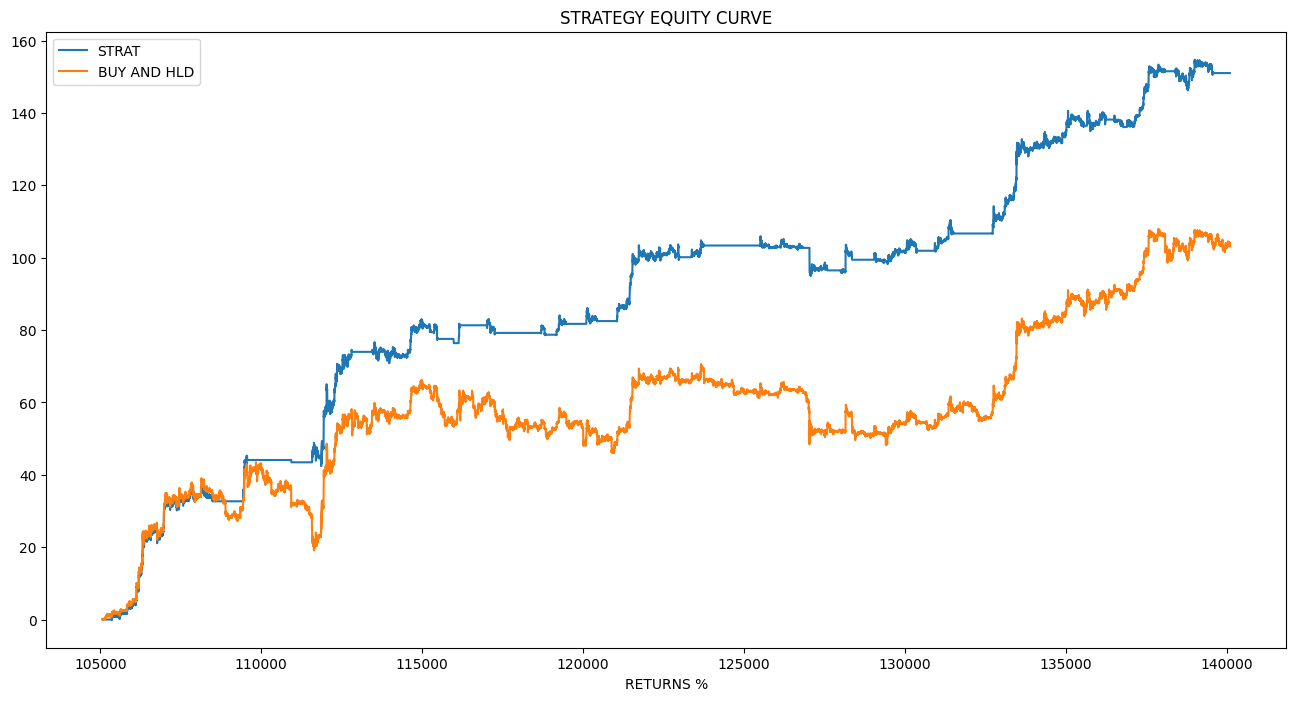

In [ ]:
plt.figure(figsize = (16,8))
plt.plot(df['pnl'].cumsum())
plt.plot(df['pct_change'].cumsum())
plt.xlabel( 'TICKS')
plt.xlabel( 'RETURNS %')
plt.title('STRATEGY EQUITY CURVE')
plt.legend( ['STRAT' , 'BUY AND HLD'] )
print( 'STRATEGY RETURS{} '.format(df['pnl'].cumsum().iloc[-1]) )
print('BUY&HLD RETURNS {}'.format(df['pct_change'].cumsum().iloc[-1]) )

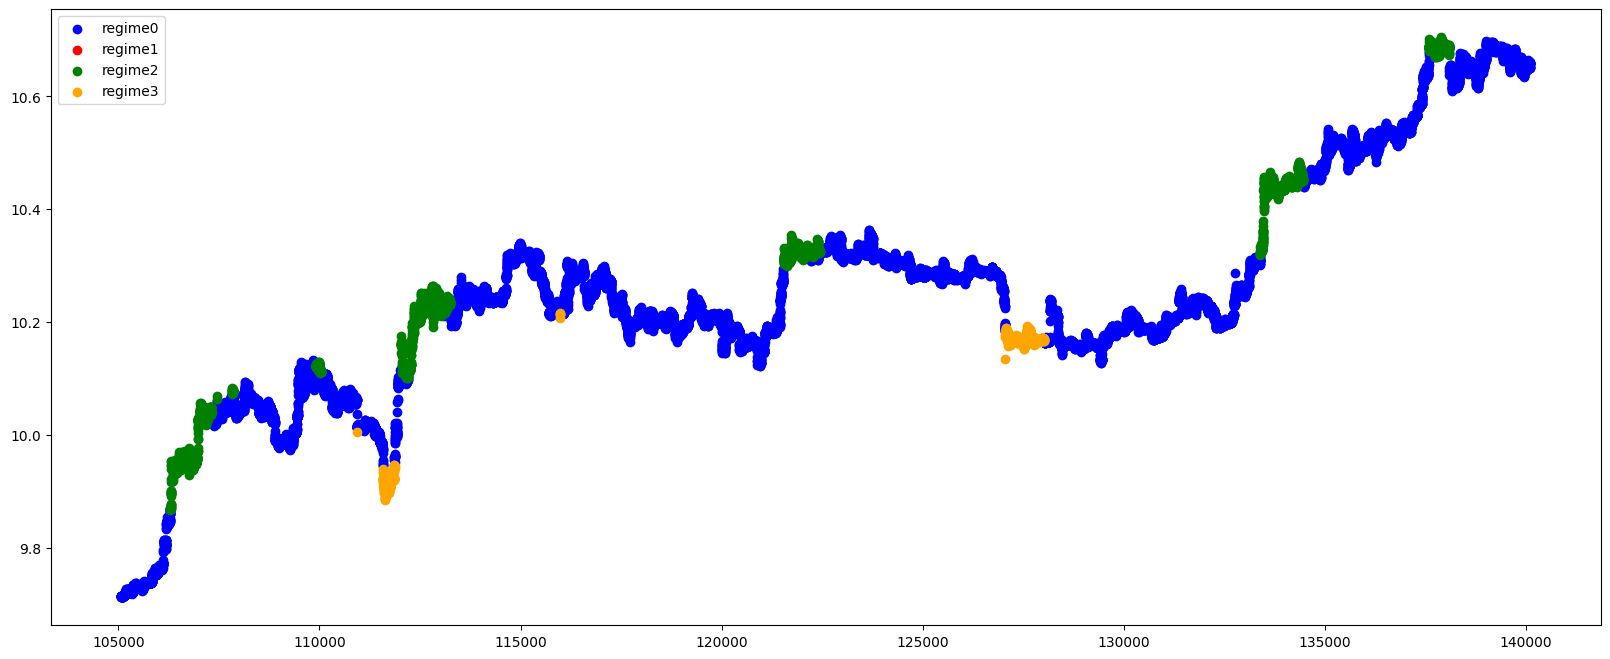

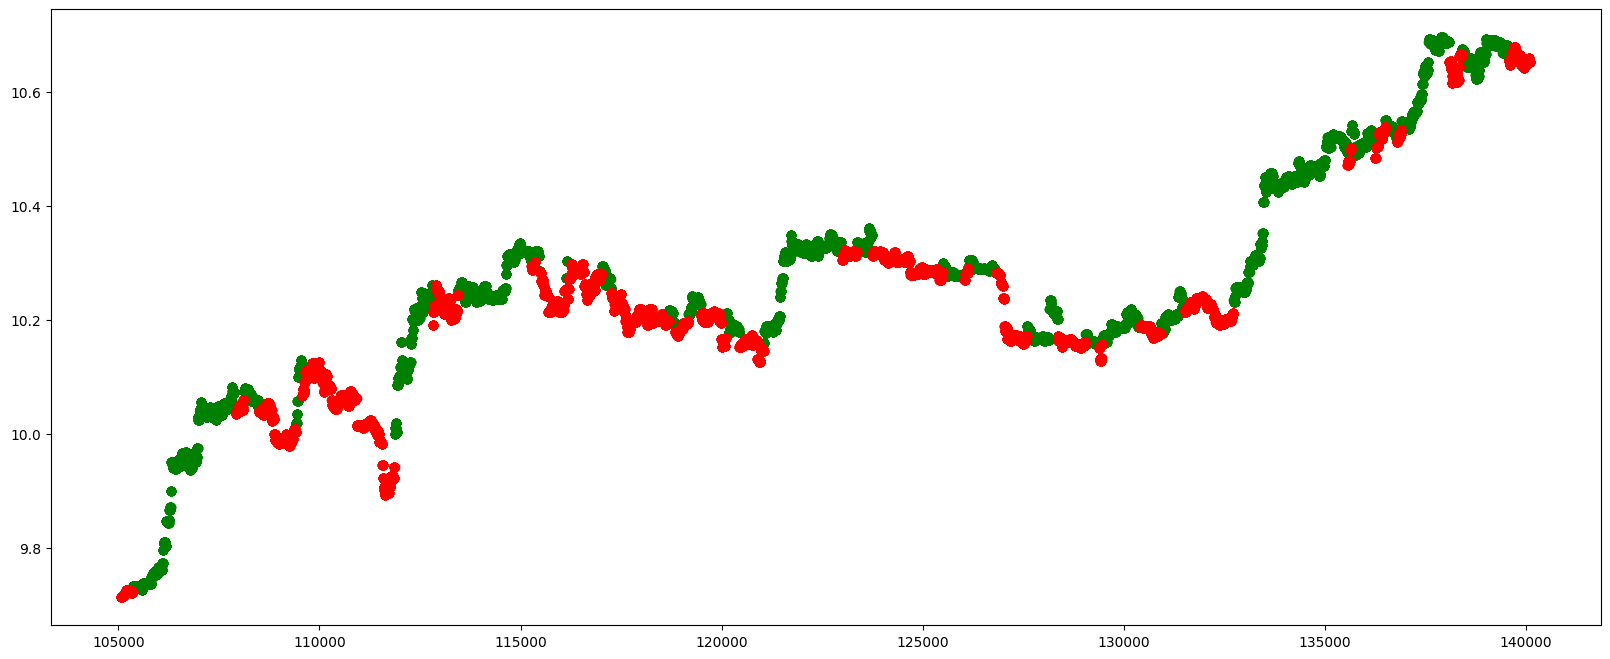

In [ ]:
df['log_close'] = np.log(df.close)
df['regime0'] = np.where( df.regime ==0 , df.log_close , np.nan)
df['regime1'] = np.where( df.regime ==1 , df.log_close , np.nan)
df['regime2'] = np.where( df.regime ==2 , df.log_close , np.nan)
df['regime3'] = np.where( df.regime ==3 , df.log_close , np.nan)
plt.figure(figsize =( 20,8))
plt.scatter ( df.index , df['regime0'] , color = 'blue' )
plt.scatter ( df.index , df['regime1'] , color = 'red' )
plt.scatter ( df.index , df['regime2'] , color = 'green'  )
plt.scatter ( df.index , df['regime3'], color = 'orange')
plt.legend(['regime0','regime1' , 'regime2' , 'regime3'])


df['log_close_l'] = np.log(df.close_l)
df['regime0_l'] = np.where( df.signal_l == 1 , df.log_close_l , np.nan)
df['regime1_l'] = np.where( df.signal_l == -1 , df.log_close_l , np.nan)
plt.figure(figsize =( 20,8))
plt.scatter ( df.index , df['regime0_l'] , color = 'green' )
plt.scatter ( df.index , df['regime1_l'] , color = 'red' )

In [ ]:
slice_ = int( len(df)*0.7 )
df2 = df[ slice_: ].copy()

df2['%'] = df2.close.pct_change()
df2['mean'] = df2['%'].rolling(1000).mean()
df2['std'] = df2['%'].rolling(1000).std()
df2.dropna(inplace = True)

dff = df2[['mean' , 'std']].copy()


#ss= StandardScaler()

#unsup = mix.GaussianMixture( n_components = 4 , \
#                      covariance_type = 'spherical' ,\
#                      n_init = 100 ,\
#                     random_state = 42)

#unsup.fit(  ss.fit_transform(dff) )
regime = unsup.predict( ss.transform(dff) )

df2['regime'] = regime
df2

In [ ]:
df2['log_close'] = np.log(df2.close)
df2['regime0'] = np.where( df2.regime ==0 , df2.log_close , np.nan)
df2['regime1'] = np.where( df2.regime ==1 , df2.log_close , np.nan)
df2['regime2'] = np.where( df2.regime ==2 , df2.log_close , np.nan)
df2['regime3'] = np.where( df2.regime ==3 , df2.log_close , np.nan)
plt.figure(figsize =( 20,8))
plt.scatter ( df2.index , df2['regime0'] , color = 'blue' )
plt.scatter ( df2.index , df2['regime1'] , color = 'red' )
plt.scatter ( df2.index , df2['regime2'] , color = 'green'  )
plt.scatter ( df2.index , df2['regime3'], color = 'orange')
plt.legend(['regime0','regime1' , 'regime2' , 'regime3'])

new

In [ ]:
slice_ = int( len(df)*0.7 )
df1 = df[:slice_].copy()

df1['rsi'] = ta.rsi(close = df1.close , length = 14).shift(1)
df1['rsi'] = df1['rsi'].rolling(window = 1000).mean()
#df1['atr'] = ta.atr(high = df1.high , low = df1.low , close = df1.close , length = 14).shift(1)
#df1['atr'] = df1['atr'].rolling(window = 1000).mean()
df1['adx'] = ta.adx( high = df1.high , low = df1.low , close = df1.close , length = 14).shift(1)['ADX_14'].shift(1)
df1['adx'] = df1['adx'].rolling(window = 1000).mean()
#df1['roc'] = ta.roc(close = df1.close , legth = 14).shift(1)
#df1['roc'] = df1['roc'].rolling(window = 1000).mean()


df1.dropna(inplace = True)

dff = df1[['rsi' , 'adx']].copy()


ss= StandardScaler()


unsup = mix.GaussianMixture( n_components = 4 , \
                      covariance_type = 'spherical' ,\
                      n_init = 100 ,\
                      random_state = 42)



unsup.fit(  ss.fit_transform(dff) )
regime = unsup.predict( ss.transform(dff) )

df1['regime'] = regime
df1

,datetime,open,high,low,close,volume,open_l,high_l,low_l,close_l,volume_l,supertrend_l,signal_l,rsi,adx,regime
1028,2018-01-12 00:15:00,13802.92,13802.92,13620.00,13661.50,198.256168,13950.05,14190.00,13205.58,13430.16,2789.528860,15742.893231,-1.0,50.534906,24.505327,2
1029,2018-01-12 00:30:00,13661.35,13772.52,13648.52,13704.32,121.230008,13950.05,14190.00,13205.58,13430.16,2789.528860,15742.893231,-1.0,50.515780,24.488995,2
1030,2018-01-12 00:45:00,13704.31,13749.00,13667.61,13705.00,76.424363,13950.05,14190.00,13205.58,13430.16,2789.528860,15742.893231,-1.0,50.504434,24.471545,2
1031,2018-01-12 01:00:00,13705.00,13750.00,13333.40,13390.74,254.465316,13950.05,14190.00,13205.58,13430.16,2789.528860,15742.893231,-1.0,50.496881,24.454797,2
1032,2018-01-12 01:15:00,13356.67,13470.00,13205.58,13430.16,251.873637,13950.05,14190.00,13205.58,13430.16,2789.528860,15742.893231,-1.0,50.484029,24.438891,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122266,2021-07-03 01:15:00,33204.98,33344.19,33160.52,33327.71,380.833480,33704.90,33795.16,33109.76,33327.71,7029.745196,35860.793378,-1.0,50.116556,24.869210,2
122267,2021-07-03 01:30:00,33327.71,33331.55,33158.06,33200.00,343.258214,33327.71,33898.95,33041.65,33786.55,6627.275987,35860.793378,-1.0,50.132856,24.858048,2
122268,2021-07-03 01:45:00,33201.14,33203.07,33041.65,33180.68,413.373150,33327.71,33898.95,33041.65,33786.55,6627.275987,35860.793378,-1.0,50.146455,24.843861,2
122269,2021-07-03 02:00:00,33179.08,33233.81,33120.00,33200.36,203.064803,33327.71,33898.95,33041.65,33786.55,6627.275987,35860.793378,-1.0,50.158350,24.827423,2


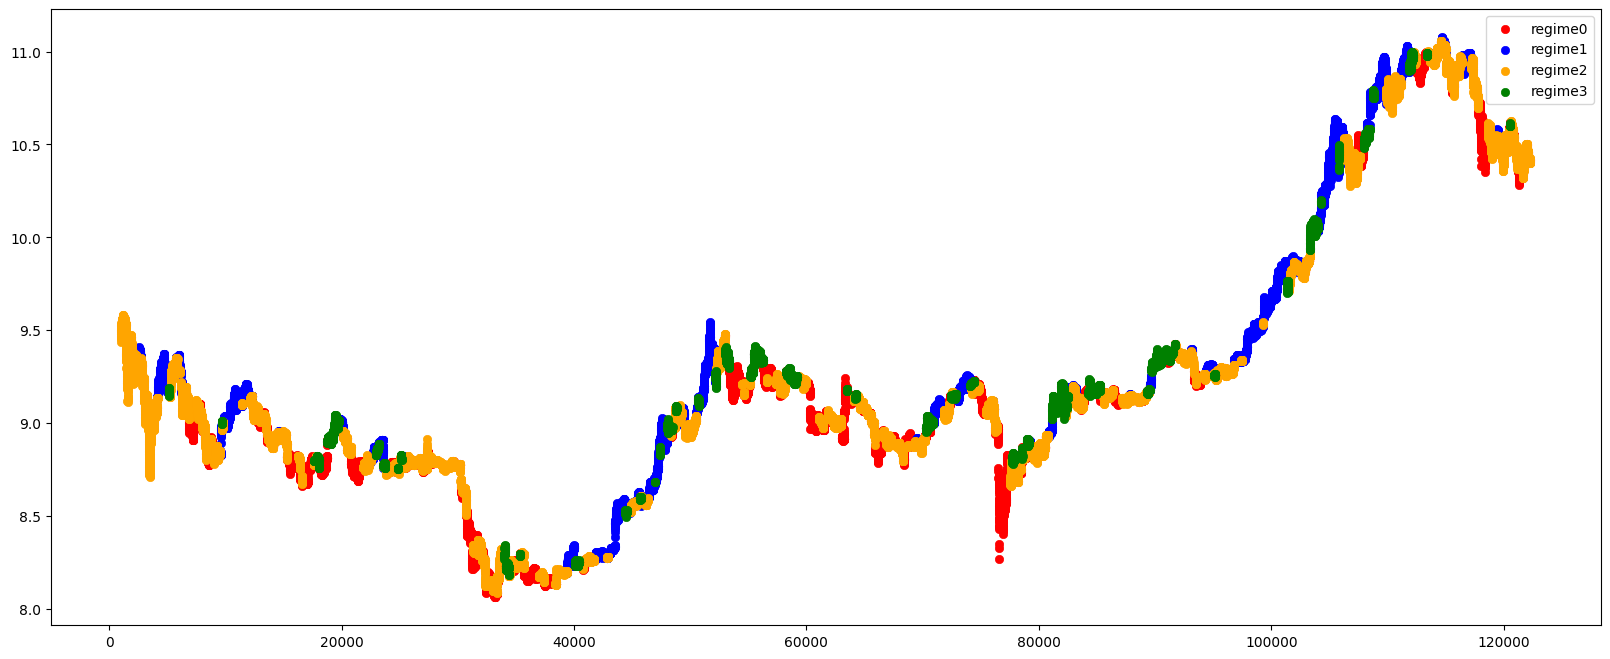

In [ ]:
df1['log_close'] = np.log(df1.close)
df1['regime0'] = np.where( df1.regime ==0 , df1.log_close , np.nan)
df1['regime1'] = np.where( df1.regime ==1 , df1.log_close , np.nan)
df1['regime2'] = np.where( df1.regime ==2 , df1.log_close , np.nan)
df1['regime3'] = np.where( df1.regime ==3 , df1.log_close , np.nan)
plt.figure(figsize =( 20,8))
plt.scatter ( df1.index , df1['regime0'] , color = 'red' , linewidths=0.5 )
plt.scatter ( df1.index , df1['regime1'] , color = 'blue', linewidths=0.5  )
plt.scatter ( df1.index , df1['regime2'] , color = 'orange', linewidths=0.5   )
plt.scatter ( df1.index , df1['regime3'], color = 'green', linewidths=0.5 )
plt.legend(['regime0','regime1' , 'regime2' , 'regime3'])

In [ ]:
df_par =   pd.DataFrame( [  [ np.mean(df1[df1.regime == rg]['rsi'].to_list()),      \
                              np.mean(df1[df1.regime == rg]['adx'].to_list())  ]    \
                              for rg in [0,1,2,3]  ] ,                              \
                              columns = ['rsi' , 'adx' ]   )


df_par = df_par
df_par.index = ['regime0' , 'regime1' , 'regime2' , 'regime3']
print(df_par)

               rsi        adx
regime0  48.685337  27.880183
regime1  52.859657  24.608143
regime2  49.867488  25.547200
regime3  52.840181  27.874300


Text(0, 0.5, 'adx')

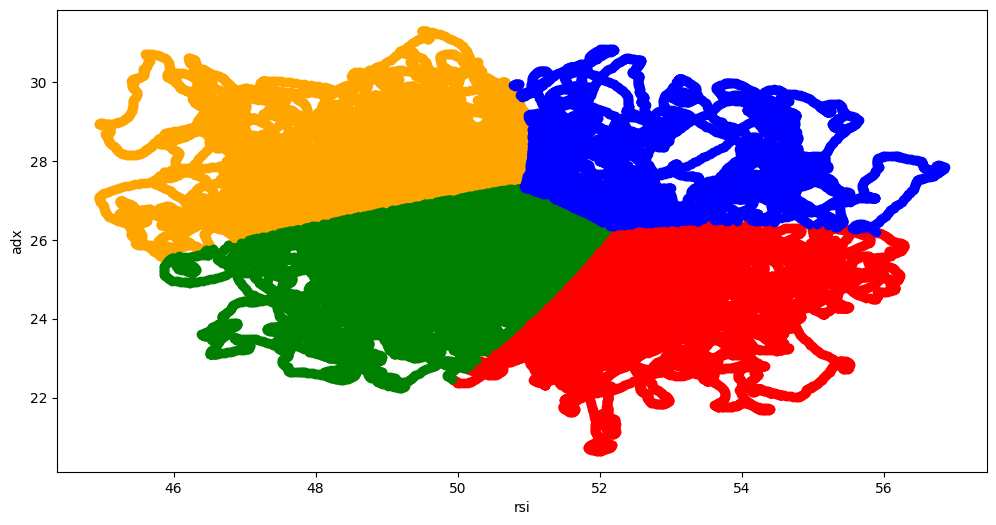

In [ ]:
rg0 = df1[df1.regime == 0]
rg1 = df1[df1.regime == 1]
rg2 = df1[df1.regime == 2]
rg3 = df1[df1.regime == 3]

plt.figure(figsize = (12,6))
plt.scatter(rg0['rsi'] , rg0['adx'] , color = 'orange')
plt.scatter(rg1['rsi'] , rg1['adx'], color = 'red')
plt.scatter(rg2['rsi'] , rg2['adx'], color = 'green')
plt.scatter(rg3['rsi'] , rg3['adx'], color = 'blue')
plt.xlabel('rsi')
plt.ylabel('adx')